In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

In [61]:
from sam2.utils.masks_finder import mask_finder

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:9")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


In [63]:
torch.cuda.device_count()

10

In [64]:
import os

In [65]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [66]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [67]:
#video_path ="/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/sam2/notebooks/videos/bedroom.mp4"
video_dir = "/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/sam2/notebooks/videos/road"

In [68]:

'''
os.makedirs(video_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = os.path.join(video_dir, f"{frame_idx:04d}.jpg")
    cv2.imwrite(frame_path, frame)
    frame_idx += 1

cap.release()
print(f"Extracted {frame_idx} frames to '{video_dir}'")
'''

'\nos.makedirs(video_dir, exist_ok=True)\n\ncap = cv2.VideoCapture(video_path)\nframe_idx = 0\n\nwhile cap.isOpened():\n    ret, frame = cap.read()\n    if not ret:\n        break\n    frame_path = os.path.join(video_dir, f"{frame_idx:04d}.jpg")\n    cv2.imwrite(frame_path, frame)\n    frame_idx += 1\n\ncap.release()\nprint(f"Extracted {frame_idx} frames to \'{video_dir}\'")\n'

In [69]:
'''

import os


# Get all .jpg/.jpeg files (case insensitive)
image_files = [
    f for f in os.listdir(video_dir)
    if os.path.splitext(f)[-1].lower() in [".jpg", ".jpeg"]
]

# Sort by the original filename or extract a frame number if needed
image_files.sort()  # or use a custom key as needed

# Rename each file
for idx, filename in enumerate(image_files):
    new_name = f"{idx:04d}.jpg"
    src = os.path.join(video_dir, filename)
    dst = os.path.join(video_dir, new_name)
    os.rename(src, dst)

print("Renaming complete.")

'''


'\n\nimport os\n\n\n# Get all .jpg/.jpeg files (case insensitive)\nimage_files = [\n    f for f in os.listdir(video_dir)\n    if os.path.splitext(f)[-1].lower() in [".jpg", ".jpeg"]\n]\n\n# Sort by the original filename or extract a frame number if needed\nimage_files.sort()  # or use a custom key as needed\n\n# Rename each file\nfor idx, filename in enumerate(image_files):\n    new_name = f"{idx:04d}.jpg"\n    src = os.path.join(video_dir, filename)\n    dst = os.path.join(video_dir, new_name)\n    os.rename(src, dst)\n\nprint("Renaming complete.")\n\n'

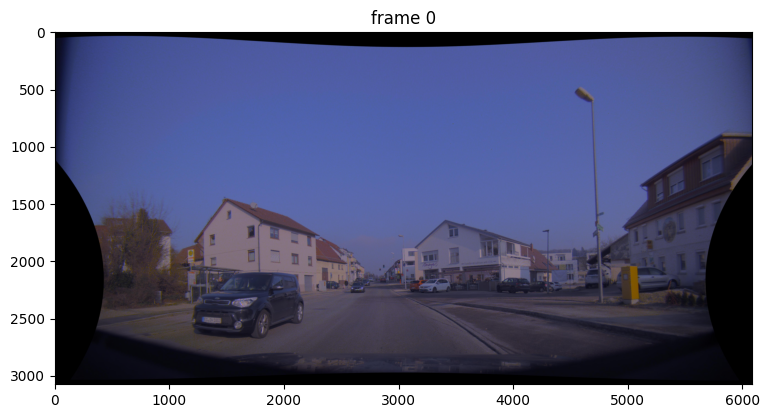

In [70]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [71]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 450/450 [02:27<00:00,  3.05it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.27 GiB. GPU 0 has a total capacity of 15.56 GiB of which 4.96 GiB is free. Process 666553 has 2.48 GiB memory in use. Process 3408135 has 774.00 MiB memory in use. Process 2518896 has 2.09 GiB memory in use. Including non-PyTorch memory, this process has 1.29 GiB memory in use. Process 3491381 has 3.96 GiB memory in use. Of the allocated memory 1.11 GiB is allocated by PyTorch, and 52.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
predictor.reset_state(inference_state)

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
obj_id=1
# Let's add a positive click at (x, y) = (210, 350) to get started
#points = np.array([[1500, 2250]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
#labels = np.array([1], np.int32)
'''
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
'''
initial_mask_link='/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/data/ALLIANCE-DC01-IMU_LBXR268-D-002_20240112_111253_FC1_f00001_RGB_ContextA_rectified.png'

masks=mask_finder(initial_mask_link)

for mask in masks:
    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=obj_id+1,
        mask=mask,
)
    obj_id+=1


# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
#show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

OutOfMemoryError: CUDA out of memory. Tried to allocate 286.00 MiB. GPU 3 has a total capacity of 15.56 GiB of which 174.56 MiB is free. Including non-PyTorch memory, this process has 7.47 GiB memory in use. Process 3491381 has 7.91 GiB memory in use. Of the allocated memory 6.95 GiB is allocated by PyTorch, and 386.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
out_obj_ids

[2]

In [28]:
out_mask_logits.shape

torch.Size([1, 1, 3074, 6090])

IndexError: list index out of range

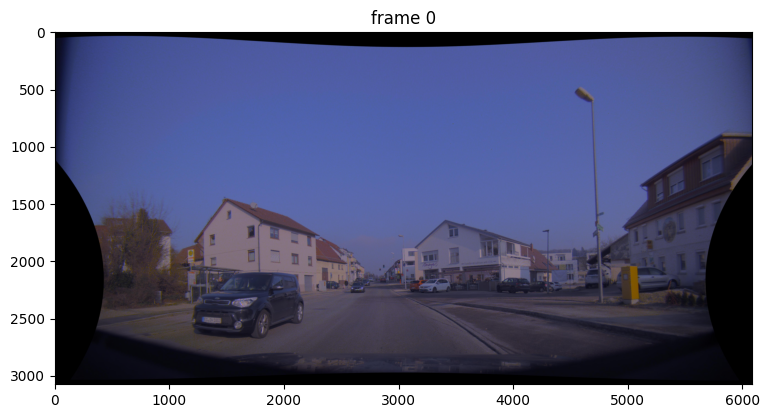

In [25]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
#show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[1])

In [ ]:
# For each class in the mask
for class_id in np.unique(masks):
    if class_id == 0:
        continue  # optionally skip background
    binary_mask = (class_mask == class_id).astype(np.uint8)
    show_mask(binary_mask, ax, obj_id=class_id)  # use class_id to color

plt.show()

propagate in video:   0%|          | 0/450 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 450/450 [03:23<00:00,  2.21it/s]


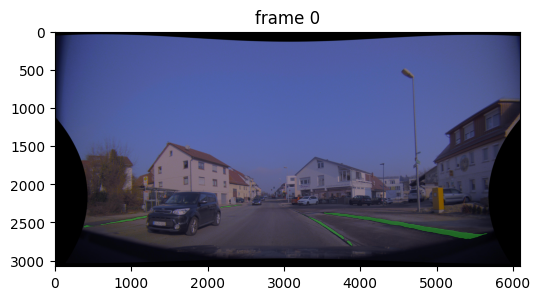

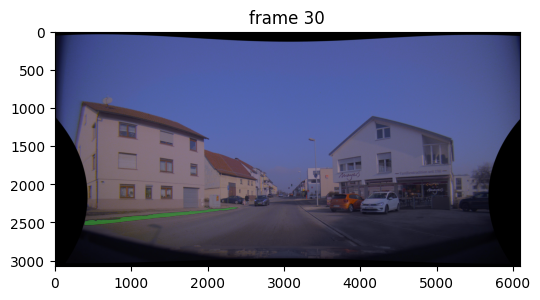

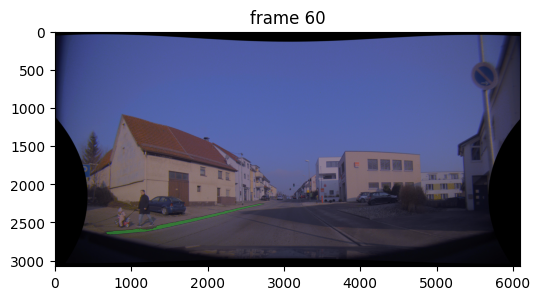

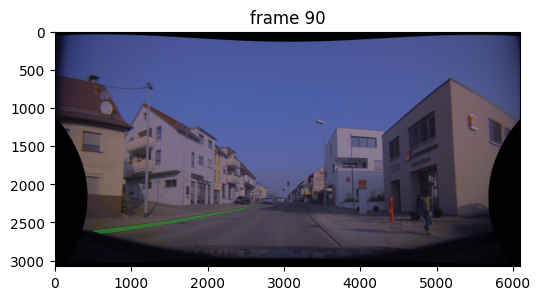

Error in callback <function flush_figures at 0x7f936ce70f70> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [23]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "./output_masks/road"
os.makedirs(output_dir, exist_ok=True)

video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

for out_frame_idx in range(len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.imshow(img)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    plt.axis('off')

    output_path = os.path.join(output_dir, f"frame_{out_frame_idx:05d}.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


propagate in video:   0%|          | 0/450 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 450/450 [04:26<00:00,  1.69it/s]


In [ ]:
import cv2
import os
import glob

def frames_to_video(frame_dir, output_path, fps=10):
    frame_files = sorted(glob.glob(os.path.join(frame_dir, '*.png')))

    if not frame_files:
        print("No frames found in:", frame_dir)
        return

    # Read the first frame to get the dimensions
    frame = cv2.imread(frame_files[0])
    height, width, _ = frame.shape

    # Define video codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        out.write(frame)

    out.release()
    print(f"Video saved to: {output_path}")

In [ ]:
frames=len(frame_names)
time_in_sec=6
fps=frames/time_in_sec

In [ ]:
output_dir="/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/data/output_masks"

In [ ]:
frames_to_video(output_dir, '/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/sam2/output_tracked_videos/bedroom_tracked.mp4', fps=fps)


Video saved to: /media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/sam2/output_tracked_videos/bedroom_tracked.mp4
